# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv;
- /datasets/geo_data_1.csv;
- /datasets/geo_data_2.csv.

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- бюджет на разработку скважин в регионе — 10 млрд рублей.
- при нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Для выполнения данного проекта необходимо:**

1. Загрузить и подготовить данные (загрузка, предобработка, исследовательский анализ).
2. Обучить и проверить модель для каждого региона.
3. Подготовка к расчёту прибыли (расчет достаточного объёма сырья для безубыточной разработки новой скважины).
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
5. Посчитать риски и прибыль для каждого региона.
6. Написать выводы.

In [1]:
!pip install phik
!pip install shap 
!pip install -U scikit-learn

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 63.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

### Загрузка данных

In [3]:
#считывание csv-файлов и сохранение в датафреймы
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

In [4]:
# получение первых 10 строк датафрейма geo_data_0
geo_data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [5]:
# вывод основной информации о датафрейме geo_data_0
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
# получение первых 10 строк датафрейма geo_data_1
geo_data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [7]:
# вывод основной информации о датафрейме geo_data_1
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
# получение первых 10 строк датафрейма geo_data_2
geo_data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [9]:
# вывод основной информации о датафрейме geo_data_2
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Предобработка данных

In [10]:
# определение количества дубликатов в датафрейме geo_data_0
geo_data_0.duplicated().sum()

0

In [11]:
# определение количества дубликатов в датафрейме geo_data_1
geo_data_1.duplicated().sum()

0

In [12]:
# определение количества дубликатов в датафрейме geo_data_2
geo_data_2.duplicated().sum()

0

### Исследовательский анализ данных

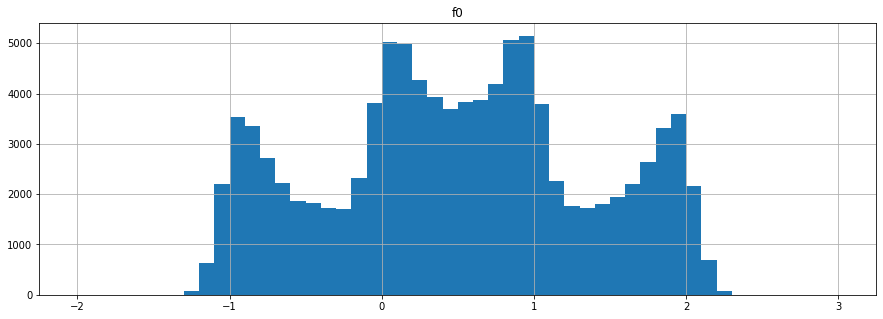

In [13]:
#построение гистограммы по столбцу f0
geo_data_0['f0'].hist(bins=50, range = (-2, 3), figsize=(15, 5));
plt.title('f0');

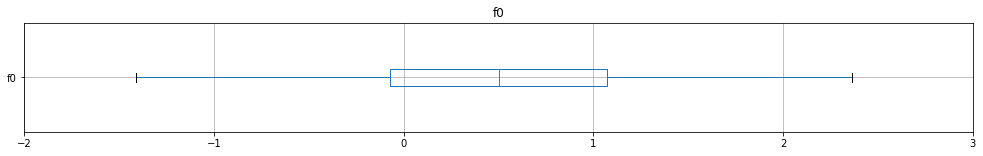

In [14]:
# построение диаграммы размаха по столбцу f0
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_0[['f0']].boxplot(vert = False, ax =ax)
ax.set_title('f0')
ax.set_xlim(-2, 3);

In [15]:
# вывод числового описания данных 
geo_data_0['f0'].describe()

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

По полученным данным можно сказать, что распределение признака f0 датафрейма geo_data_0 не является нормальным, не имеет выбросов, а среднее значение и медиана данного признака близки.

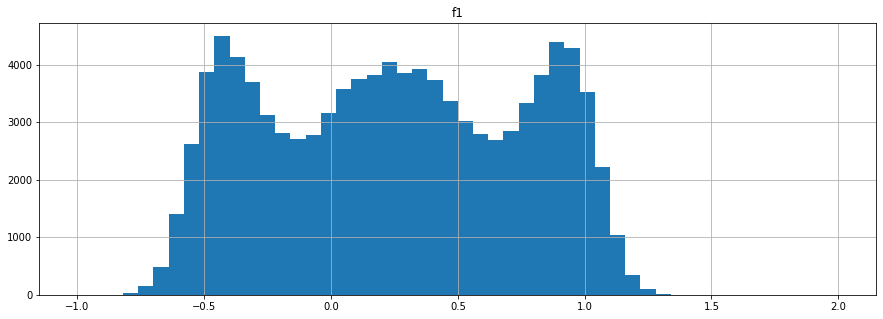

In [16]:
#построение гистограммы по столбцу f1
geo_data_0['f1'].hist(bins=50, range = (-1, 2), figsize=(15, 5));
plt.title('f1');

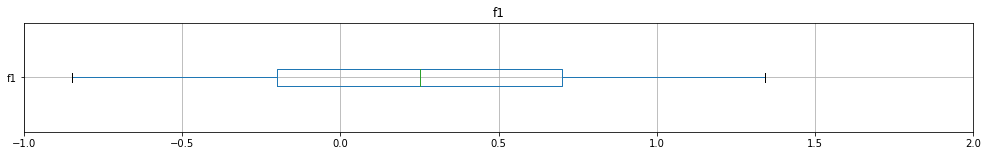

In [17]:
# построение диаграммы размаха по столбцу f1
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_0[['f1']].boxplot(vert = False, ax =ax)
ax.set_title('f1')
ax.set_xlim(-1, 2);

In [18]:
# вывод числового описания данных 
geo_data_0['f1'].describe()

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

По полученным данным можно сказать, что распределение признака f1 датафрейма geo_data_0 не является нормальным, не имеет выбросов, а среднее значение и медиана данного признака близки.

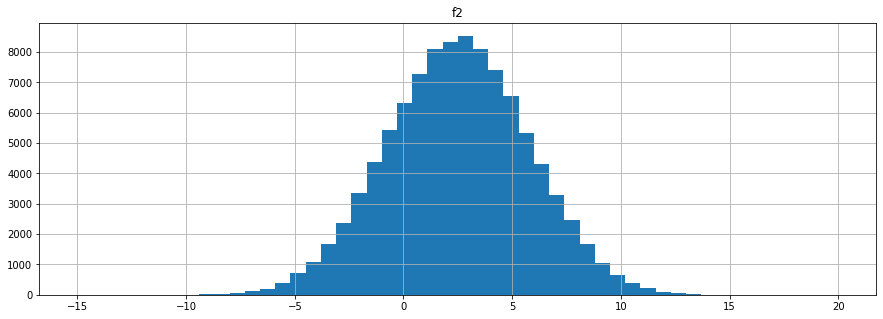

In [19]:
#построение гистограммы по столбцу f2
geo_data_0['f2'].hist(bins=50, range = (-15, 20), figsize=(15, 5));
plt.title('f2');

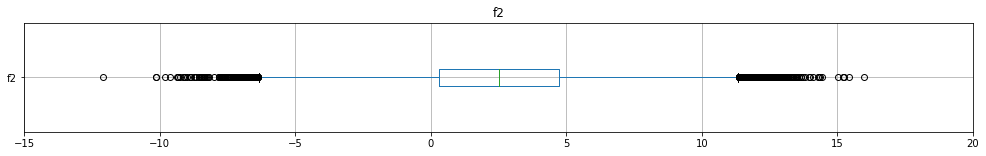

In [20]:
# построение диаграммы размаха по столбцу f2
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_0[['f2']].boxplot(vert = False, ax =ax)
ax.set_title('f2')
ax.set_xlim(-15, 20);

In [21]:
# вывод числового описания данных 
geo_data_0['f2'].describe()

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

По полученным данным можно сказать, что распределение признака f2 датафрейма geo_data_0 является нормальным, но имеет большое количество выбросов, а среднее значение и медиана данного признака близки.

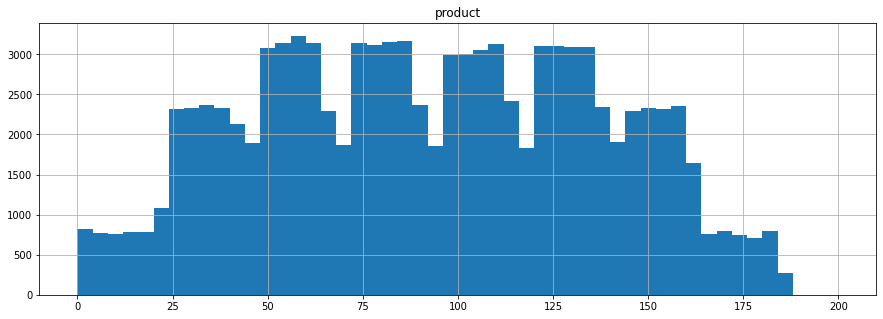

In [22]:
#построение гистограммы по столбцу product
geo_data_0['product'].hist(bins=50, range = (0, 200), figsize=(15, 5));
plt.title('product');

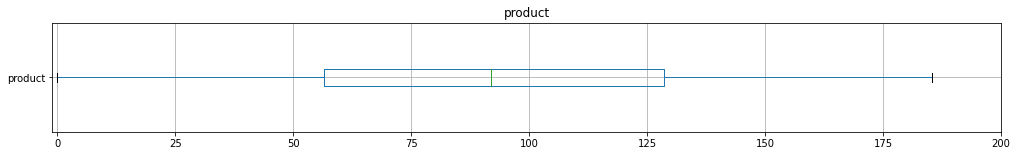

In [23]:
# построение диаграммы размаха по столбцу product
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_0[['product']].boxplot(vert = False, ax =ax)
ax.set_title('product')
ax.set_xlim(-1, 200);

In [24]:
# вывод числового описания данных 
geo_data_0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

По полученным данным можно сказать, что распределение признака product датафрейма geo_data_0 не является нормальным, не имеет выбросов, а среднее значение и медиана данного признака близки. Также стоит отметить большое значение среднего отклонения данного признака.

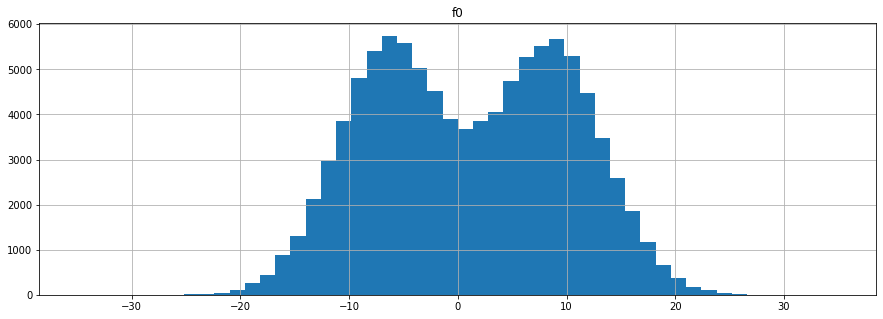

In [25]:
#построение гистограммы по столбцу f0
geo_data_1['f0'].hist(bins=50, range = (-35, 35), figsize=(15, 5));
plt.title('f0');

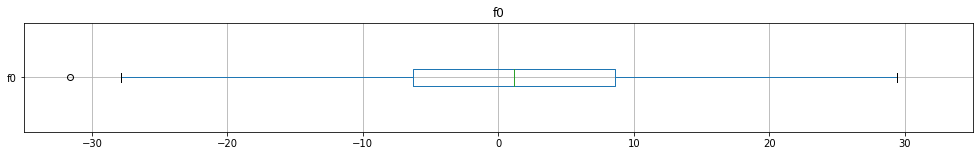

In [26]:
# построение диаграммы размаха по столбцу f0
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_1[['f0']].boxplot(vert = False, ax =ax)
ax.set_title('f0')
ax.set_xlim(-35, 35);

In [27]:
# вывод числового описания данных 
geo_data_1['f0'].describe()

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

По полученным данным можно сказать, что распределение признака f0 датафрейма geo_data_1 не является нормальным (имеются два пика при значениях, равных -7 и 9), не имеет выбросов, а среднее значение и медиана данного признака близки.

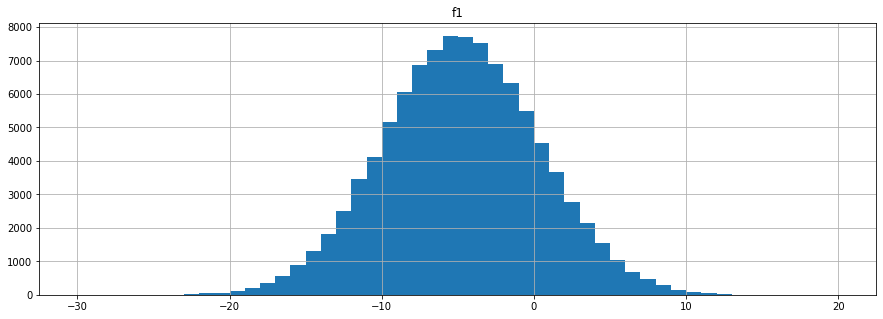

In [28]:
#построение гистограммы по столбцу f1
geo_data_1['f1'].hist(bins=50, range = (-30, 20), figsize=(15, 5));
plt.title('f1');

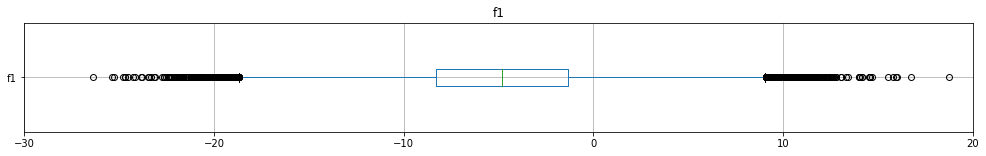

In [29]:
# построение диаграммы размаха по столбцу f1
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_1[['f1']].boxplot(vert = False, ax =ax)
ax.set_title('f1')
ax.set_xlim(-30, 20);

In [30]:
# вывод числового описания данных 
geo_data_1['f1'].describe()

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64

По полученным данным можно сказать, что распределение признака f1 датафрейма geo_data_1 является нормальным (пик при значении, равном -5), но имеет большое количество выбросов, а среднее значение и медиана данного признака близки.

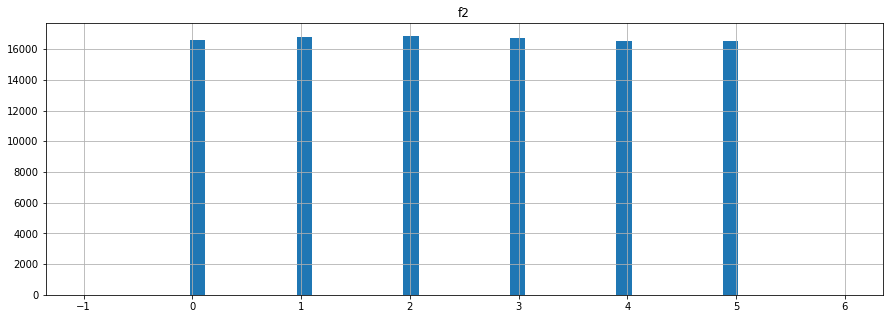

In [31]:
#построение гистограммы по столбцу f2
geo_data_1['f2'].hist(bins=50, range = (-1, 6), figsize=(15, 5));
plt.title('f2');

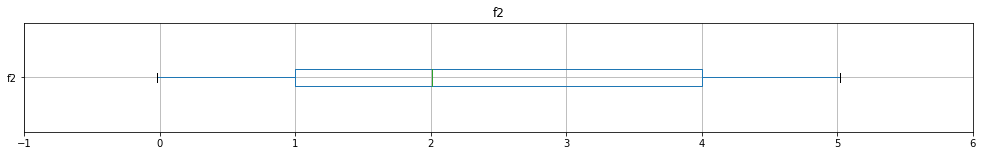

In [32]:
# построение диаграммы размаха по столбцу f2
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_1[['f2']].boxplot(vert = False, ax =ax)
ax.set_title('f2')
ax.set_xlim(-1, 6);

In [33]:
# вывод числового описания данных 
geo_data_1['f2'].describe()

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

По полученным данным можно сказать, что распределение признака f2 датафрейма geo_data_1 не является нормальным (все значения имеют почти одинаковую частоту), не имеет выбросов, а среднее значение и медиана данного признака отличны.

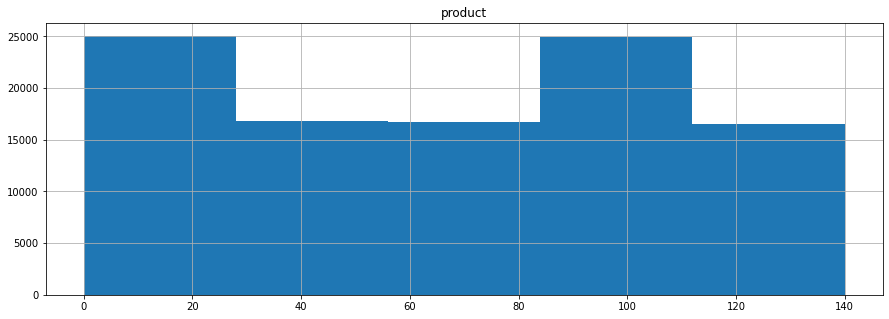

In [34]:
#построение гистограммы по столбцу product
geo_data_1['product'].hist(bins=5, range = (0, 140), figsize=(15, 5));
plt.title('product');

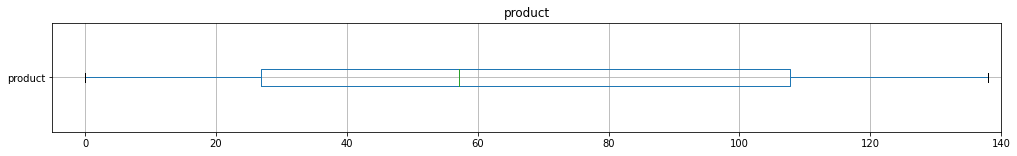

In [35]:
# построение диаграммы размаха по столбцу product
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_1[['product']].boxplot(vert = False, ax =ax)
ax.set_title('product')
ax.set_xlim(-5, 140);

In [36]:
# вывод числового описания данных 
geo_data_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

По полученным данным можно сказать, что распределение признака product датафрейма geo_data_1 не является нормальным, не имеет выбросов, а среднее значение и медиана данного признака отличны. Также стоит отметить большое значение среднего отклонения данного признака.

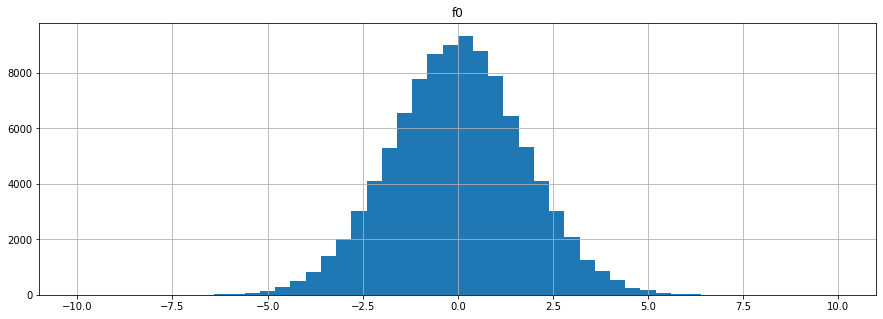

In [37]:
#построение гистограммы по столбцу f0
geo_data_2['f0'].hist(bins=50, range = (-10, 10), figsize=(15, 5));
plt.title('f0');

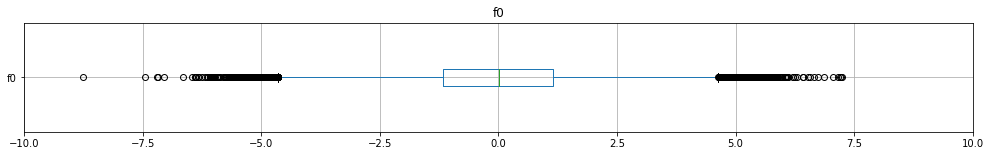

In [38]:
# построение диаграммы размаха по столбцу f0
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['f0']].boxplot(vert = False, ax =ax)
ax.set_title('f0')
ax.set_xlim(-10, 10);

In [39]:
# вывод числового описания данных 
geo_data_2['f0'].describe()

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

По полученным данным можно сказать, что распределение признака f0 датафрейма geo_data_2 является нормальным (пик при значении, равном 0), но имеет большое количество выбросов, а среднее значение и медиана данного признака близки.

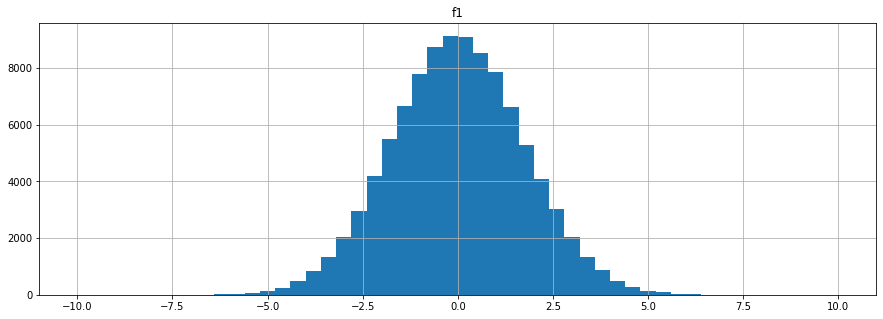

In [40]:
#построение гистограммы по столбцу f1
geo_data_2['f1'].hist(bins=50, range = (-10, 10), figsize=(15, 5));
plt.title('f1');

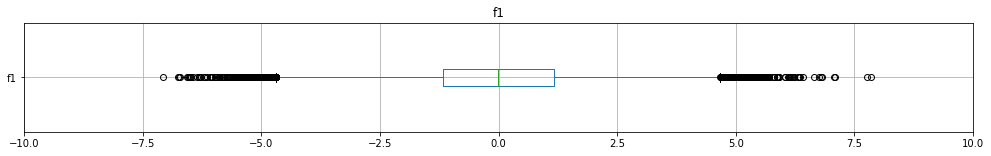

In [41]:
# построение диаграммы размаха по столбцу f1
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['f1']].boxplot(vert = False, ax =ax)
ax.set_title('f1')
ax.set_xlim(-10, 10);

In [42]:
# вывод числового описания данных 
geo_data_2['f1'].describe()

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

По полученным данным можно сказать, что распределение признака f1 датафрейма geo_data_2 является нормальным (пик при значении, равном 0), но имеет большое количество выбросов, а среднее значение и медиана данного признака близки.

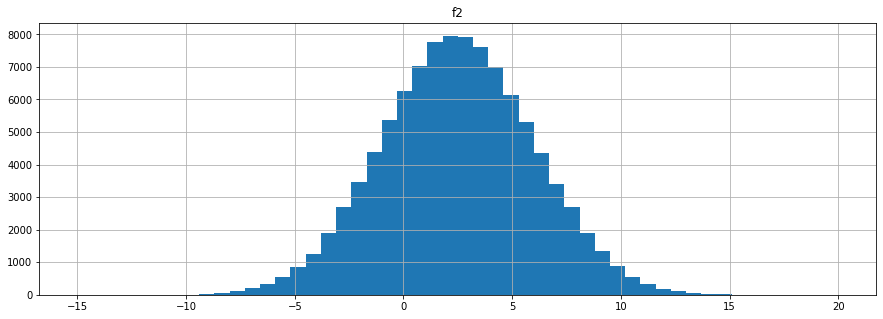

In [43]:
#построение гистограммы по столбцу f2
geo_data_2['f2'].hist(bins=50, range = (-15, 20), figsize=(15, 5));
plt.title('f2');

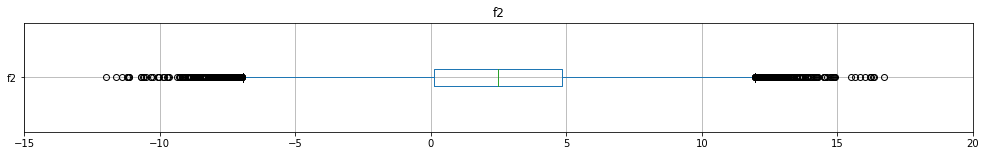

In [44]:
# построение диаграммы размаха по столбцу f2
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['f2']].boxplot(vert = False, ax =ax)
ax.set_title('f2')
ax.set_xlim(-15, 20);

In [45]:
# вывод числового описания данных 
geo_data_2['f2'].describe()

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

По полученным данным можно сказать, что распределение признака f2 датафрейма geo_data_2 является нормальным (пик при значении, равном 2,5), но имеет большое количество выбросов, а среднее значение и медиана данного признака близки.

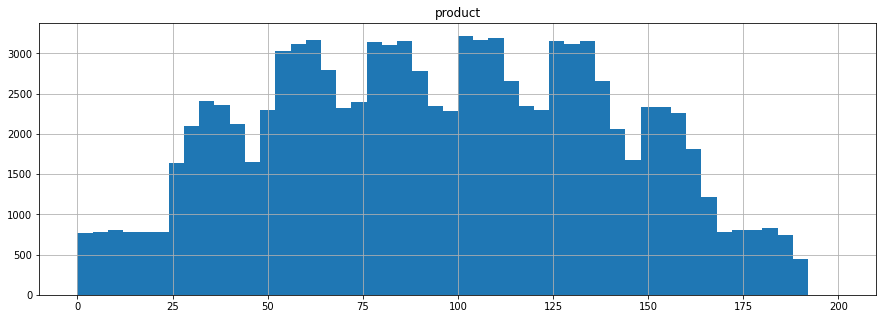

In [46]:
#построение гистограммы по столбцу product
geo_data_2['product'].hist(bins=50, range = (0, 200), figsize=(15, 5));
plt.title('product');

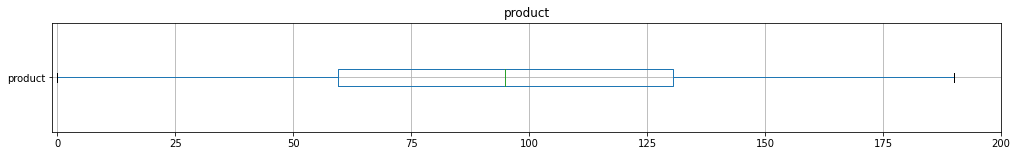

In [47]:
# построение диаграммы размаха по столбцу product
fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['product']].boxplot(vert = False, ax =ax)
ax.set_title('product')
ax.set_xlim(-1, 200);

In [48]:
# вывод числового описания данных 
geo_data_2['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

По полученным данным можно сказать, что распределение признака product датафрейма geo_data_2 не является нормальным, не имеет выбросов, а среднее значение и медиана данного признака близки. Также стоит отметить большое значение среднего отклонения данного признака.

**Вывод по результатам загрузки и подготовки данных:**

По результатам загрузки и подготовки данных можно сказать, что все датафреймы не имеют пропусков и дубликатов. При выполнении исследовательского анализа данных было выявлено, что все признаки имеют относительную большую величину среднего отклонения, часть признаков имеет нормальное распределение, но содержит большое количество выбросов согласно диаграмме размаха.

## Обучение и проверка модели

### Обучение модели для первого региона

In [49]:
RANDOM_STATE = 42

In [50]:
# сохранение входных признаков в переменную X
# сохранение целевого признака в переменную y
X = geo_data_0.drop(['id', 'product'], axis=1)
y = geo_data_0['product']

In [51]:
# разделение на тренировочную и валидационную выборки
X_train, X_valid_0, y_train, y_valid_0 = train_test_split(X, y, random_state=RANDOM_STATE)

In [52]:
num_col_names = ['f0', 'f1', 'f2']

# подготовка признаков (масштабирование)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_0_scaled = scaler.transform(X_valid_0[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_0_scaled = pd.DataFrame(X_valid_0_scaled, columns=num_col_names)

# инициалтзация модели
model_lr = LinearRegression()

# получение оптимальных значений коэффициентов
model_lr.fit(X_train, y_train)

# предсказанные значения для X_valid
predictions_0 = model_lr.predict(X_valid_0)
print("Средний запас предсказанного сырья", predictions_0.mean())

# определение RMSE
rmse_0 = mean_squared_error(y_valid_0, predictions_0, squared=False)
print("RMSE", rmse_0)

Средний запас предсказанного сырья 92.39879990657768
RMSE 37.75660035026169


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Обучение модели для второго региона

In [53]:
# сохранение входных признаков в переменную X
# сохранение целевого признака в переменную y
X = geo_data_1.drop(['id', 'product'], axis=1)
y = geo_data_1['product']

In [54]:
# разделение на тренировочную и валидационную выборки
X_train, X_valid_1, y_train, y_valid_1 = train_test_split(X, y, random_state=RANDOM_STATE)

In [55]:
num_col_names = ['f0', 'f1', 'f2']

# подготовка признаков (масштабирование)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_1_scaled = scaler.transform(X_valid_1[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_1_scaled = pd.DataFrame(X_valid_1_scaled, columns=num_col_names)

# инициалтзация модели
model_lr = LinearRegression()

# получение оптимальных значений коэффициентов
model_lr.fit(X_train, y_train)

# предсказанные значения для X_valid
predictions_1 = model_lr.predict(X_valid_1)
print("Средний запас предсказанного сырья", predictions_1.mean())

# определение RMSE
rmse_1 = mean_squared_error(y_valid_1, predictions_1, squared=False)
print("RMSE", rmse_1)

Средний запас предсказанного сырья 68.71287803913762
RMSE 0.890280100102884


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Обучение модели для третьего региона

In [56]:
# сохранение входных признаков в переменную X
# сохранение целевого признака в переменную y
X = geo_data_2.drop(['id', 'product'], axis=1)
y = geo_data_2['product']

In [57]:
# разделение на тренировочную и валидационную выборки
X_train, X_valid_2, y_train, y_valid_2 = train_test_split(X, y, random_state=RANDOM_STATE)

In [58]:
num_col_names = ['f0', 'f1', 'f2']

# подготовка признаков (масштабирование)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_2_scaled = scaler.transform(X_valid_2[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_2_scaled = pd.DataFrame(X_valid_2_scaled, columns=num_col_names)

# инициалтзация модели
model_lr = LinearRegression()

# получение оптимальных значений коэффициентов
model_lr.fit(X_train, y_train)

# предсказанные значения для X_valid
predictions_2 = model_lr.predict(X_valid_2)
print("Средний запас предсказанного сырья", predictions_2.mean())

# определение RMSE
rmse_2 = mean_squared_error(y_valid_2, predictions_2, squared=False)
print("RMSE", rmse_2)

Средний запас предсказанного сырья 94.77102387765939
RMSE 40.145872311342174


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Вывод по результатам обучения и проверки моделей:**

По данным предсказаний моделей для трех регионов можно сказать, что наибольший средний запас предсказанного сырья в третьем регионе, немного меньше в первом. Но стоит обратить внимание, что метрика RMSE минимальна во втором регионе и составляет 0.89 в отличии от двух других регионов, в которых метрика RMSE в разы превышает значение метрики второго региона.


## Подготовка к расчёту прибыли

In [59]:
# бюджет на разработку скважин в регионе
BUDGET = 1 * 10**10

In [60]:
# доход с каждой единицы продукта
REVENUE_PER_UNIT = 450000

In [73]:
# определение достаточного объема сырья для безубыточной разработки
break_even_development = BUDGET/(200*REVENUE_PER_UNIT)
break_even_development

111.11111111111111

**Вывод по результатам подготовки к расчёту прибыли:**

Полученное значение достаточного объема сырья для безубыточной разработки новой скважины выше, чем среднее значение запаса предсказанного сырья для всех трех регионов. Наибольшее значение, равное 94.8 тыс. баррелей имеет 3 регион, далее идет 1 регион со значением, равным 92.4 тыс. баррелей, меньше всего во 2 регионе - 68.7 тыс. баррелей. 


## Расчёт прибыли и рисков 

In [74]:
def pred_real_values (y_valid, X_valid):
    y_valid = pd.DataFrame(data=y_valid)
    y_valid.reset_index(drop=True, inplace=True)
    X_valid['product'] = y_valid
    return X_valid

In [75]:
X_valid_0 = pred_real_values(y_valid_0, X_valid_0)

In [76]:
X_valid_1 = pred_real_values(y_valid_1, X_valid_1)

In [77]:
X_valid_2 = pred_real_values(y_valid_2, X_valid_2)

In [78]:
def profit_function(X_valid):
    X_valid = X_valid.sort_values(by=['predictions'], ascending = False)
    X_valid.reset_index(drop=True, inplace=True)
    top_200_wells = X_valid.iloc[0:200]
    volume_sum = top_200_wells['product'].sum()
    profit = volume_sum * REVENUE_PER_UNIT
    return profit

In [79]:
def profit_distribution(X_valid):
    
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        profit_subsample = X_valid.sample(n=500, replace=True, random_state=state) 
        values.append(profit_function(profit_subsample))
        values_0 = pd.Series(values)
    return values_0

In [80]:
profit_distribution(X_valid_0)

0      1.027430e+10
1      1.057094e+10
2      1.056994e+10
3      1.038924e+10
4      1.025084e+10
           ...     
995    1.098478e+10
996    1.044962e+10
997    1.041547e+10
998    9.642378e+09
999    9.952015e+09
Length: 1000, dtype: float64

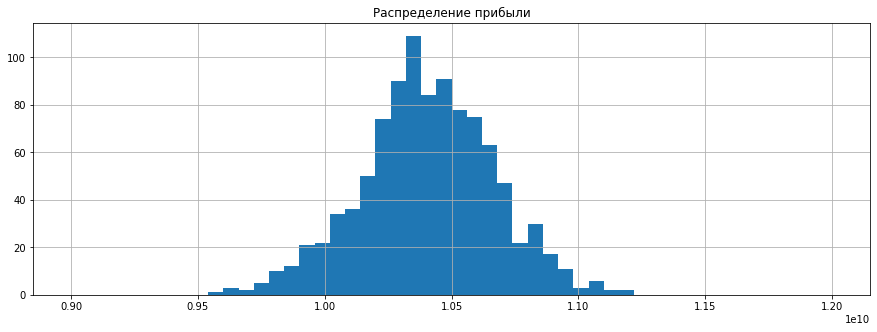

In [81]:
#построение гистограммы по столбцу product
profit_distribution(X_valid_0).hist(bins=50, range = (9000000000, 12000000000), figsize=(15, 5));
plt.title('Распределение прибыли');

In [82]:
# определение средней прибыли для 1 региона
profit_distribution(X_valid_0).mean()

10406278783.42442

In [83]:
# определение нижней границы доверительного интервала 95%
lower = profit_distribution(X_valid_0).quantile(0.025)
lower

9882257863.50513

In [84]:
# определение верхней границы доверительного интервала 95%
upper = profit_distribution(X_valid_0).quantile(0.975)
upper

10911737050.751406

In [85]:
# определение убытка при разработке 200 скважин в 1 регионе
loss = profit_distribution(X_valid_0).mean() - BUDGET
loss

406278783.4244194

In [86]:
not_profit_wells_0 = profit_distribution(X_valid_0)[profit_distribution(X_valid_0) < BUDGET]

In [87]:
risk_loss_0 = not_profit_wells_0.count()/profit_distribution(X_valid_0).count()
risk_loss_0

0.067

In [88]:
profit_distribution(X_valid_1)

0      1.041779e+10
1      1.049765e+10
2      1.070739e+10
3      1.043415e+10
4      1.044634e+10
           ...     
995    1.024008e+10
996    1.035497e+10
997    1.054045e+10
998    1.056900e+10
999    1.034072e+10
Length: 1000, dtype: float64

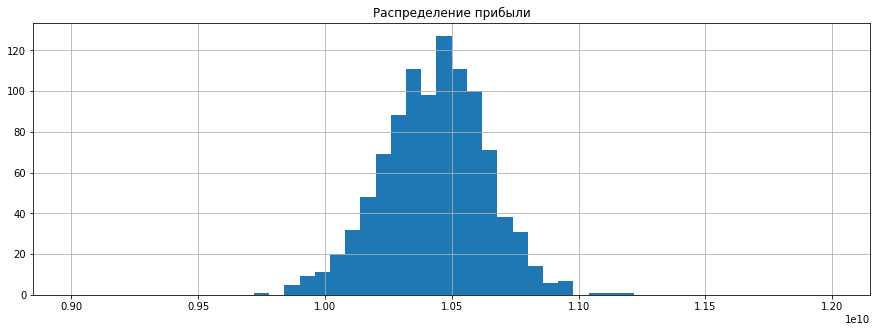

In [89]:
#построение гистограммы по столбцу product
profit_distribution(X_valid_1).hist(bins=50, range = (9000000000, 12000000000), figsize=(15, 5));
plt.title('Распределение прибыли');

In [90]:
# определение средней прибыли для 2 региона
profit_distribution(X_valid_1).mean()

10432624131.813137

In [91]:
# определение нижней границы доверительного интервала 95%
lower = profit_distribution(X_valid_1).quantile(0.025)
lower

10016846174.93243

In [92]:
# определение верхней границы доверительного интервала 95%
upper = profit_distribution(X_valid_1).quantile(0.975)
upper

10815972526.285751

In [93]:
# определение убытка при разработке 200 скважин во 2 регионе
loss = profit_distribution(X_valid_1).mean() - BUDGET
loss

432624131.81313705

In [94]:
not_profit_wells_1 = profit_distribution(X_valid_1)[profit_distribution(X_valid_1) < BUDGET]

In [95]:
risk_loss_1 = not_profit_wells_1.count()/profit_distribution(X_valid_1).count()
risk_loss_1

0.019

In [96]:
profit_distribution(X_valid_2)

0      1.033891e+10
1      1.032271e+10
2      1.002533e+10
3      1.000117e+10
4      1.042832e+10
           ...     
995    1.042833e+10
996    1.013511e+10
997    9.753758e+09
998    1.031138e+10
999    1.043135e+10
Length: 1000, dtype: float64

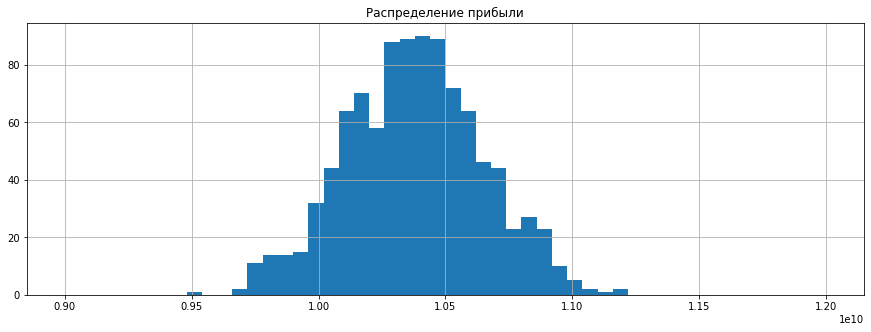

In [97]:
#построение гистограммы по столбцу product
profit_distribution(X_valid_2).hist(bins=50, range = (9000000000, 12000000000), figsize=(15, 5));
plt.title('Распределение прибыли');

In [98]:
# определение средней прибыли для 3 региона
profit_distribution(X_valid_2).mean()

10377362192.422918

In [99]:
# определение нижней границы доверительного интервала 95%
lower = profit_distribution(X_valid_2).quantile(0.025)
lower

9829219582.294273

In [100]:
# определение верхней границы доверительного интервала 95%
upper = profit_distribution(X_valid_2).quantile(0.975)
upper

10901772131.386446

In [101]:
# определение убытка при разработке 200 скважин в 3 регионе
loss = profit_distribution(X_valid_2).mean() - BUDGET
loss

377362192.4229183

In [102]:
not_profit_wells_2 = profit_distribution(X_valid_2)[profit_distribution(X_valid_2) < BUDGET]

In [103]:
risk_loss_2 = not_profit_wells_2.count()/profit_distribution(X_valid_2).count()
risk_loss_2

0.074

**Вывод по результатам расчёта прибыли и рисков:**\
При расчете прибыли в каждом регионе были получены следующие данные: наибольшая средняя прибыль наблюдается у 2-го региона и составляет 10.43 млрд рублей, а наименьшая средняя прибыль у 3-го региона - 10.38 млрд рублей.
Также были расчитаны риски убытков, по результатам расчетов можно сказать, что наибольший риск убытков наблюдается у 3-го региона и составляет 0.074, а наименьший риск наблюдается у 2-го региона и составляет 0.019. Исходя из этих данных, наиболее выгодным является второй регион.  

**Общий вывод:**\
На первом этапе были загружены данные по всем трем регионам, была проведена предобработка данных, а также были построены графики распределения для каждого признака.\
Затем были построены модели для предсказания объёма запасов в новых скважинах во всех трёх регионах. По данным предсказаний моделей можно сказать, что наибольший средний запас предсказанного сырья в третьем регионе, немного меньше в первом. Но метрика RMSE минимальна во втором регионе и составляет 0.89 в отличии от двух других регионов. Далее был определен достаточный объем сырья для безубыточной разработки новой скважины, равный 111.1 тыс. баррелей. Полученное значение выше, чем среднее значение запаса предсказанного сырья для всех трех регионов.\
Затем были отобраны 200 лучших скважин из 500 случайных точек для каждого региона по наибольшим значениям объема сырья. И для них была рассчитана суммарная прибыль по всем 200 лучшим скважинам для каждого из трех регионов. Наибольшую прибыль с 200 лучших скважин принесет 2-ой регион, его средняя прибыль составила более 10.43 млрд рублей. Следующим регионом по прибыльности является 1-ый регион, прибыль - более 10.41 млрд рублей. И наименьшая средняя прибыль у 3-го региона - 10.38 млрд рублей. При расчете рисков убытков было выявлено, что наибольший риск убытков наблюдается у 3-го региона и составляет 0.074, а наименьший риск наблюдается у 2-го региона и составляет 0.019.\
Из всего вышесказанного можно сделать вывод, что наиболее выгодным регионом для разработки скважины является второй регион, так как у этого региона наибольшая средняя прибыль и наименьший риск убытков.